✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 12:00 UTC F00 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 12:00 UTC F06 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 12:00 UTC F12 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 12:00 UTC F18 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 12:00 UTC F24 ┊ GRIB2 @ azure ┊ IDX @ azure
✅ Found ┊ model=ecmwf ┊ product=oper ┊ 2023-Oct-17 12:00 UTC F30 ┊ GRIB2 @ azure ┊ IDX @ azure


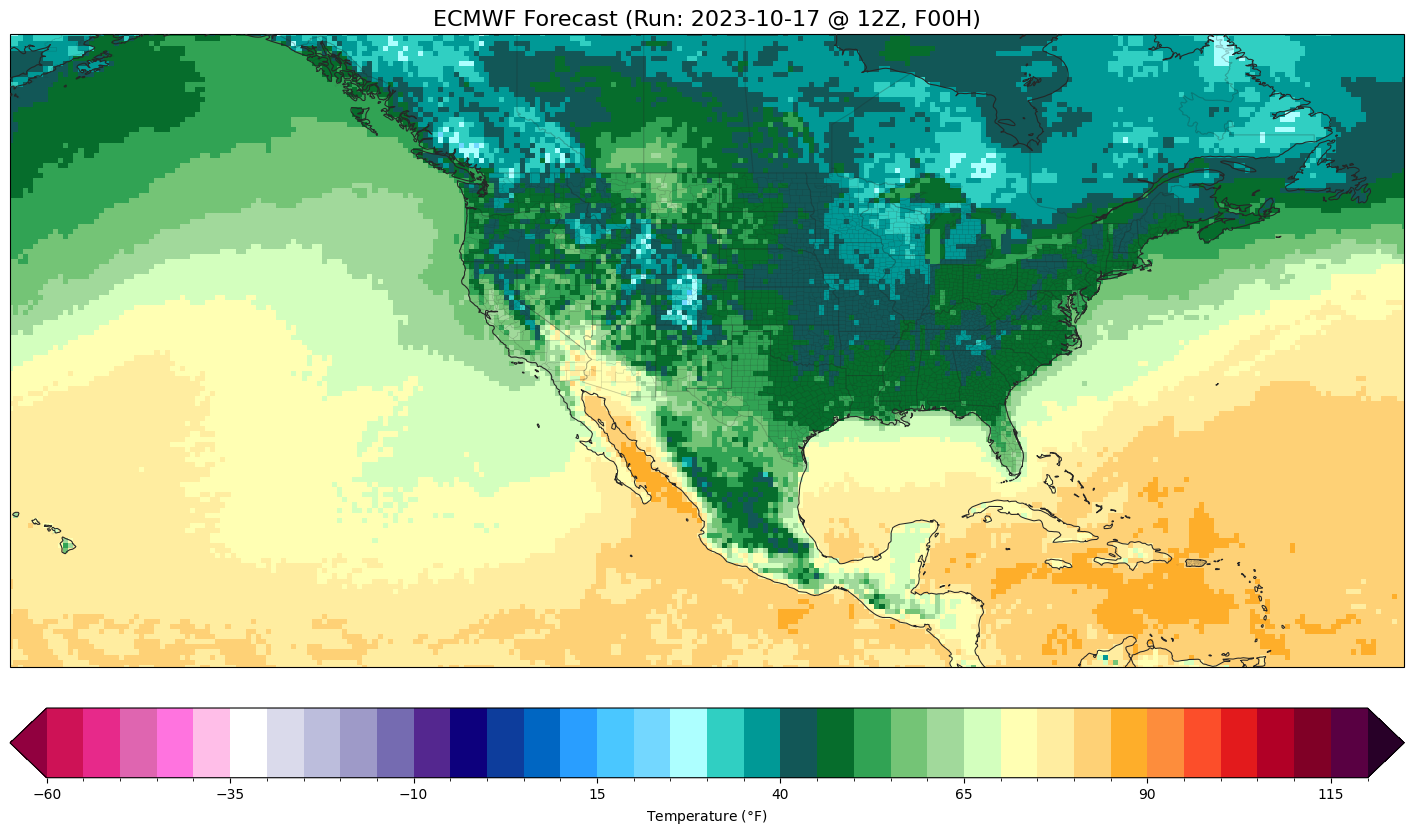

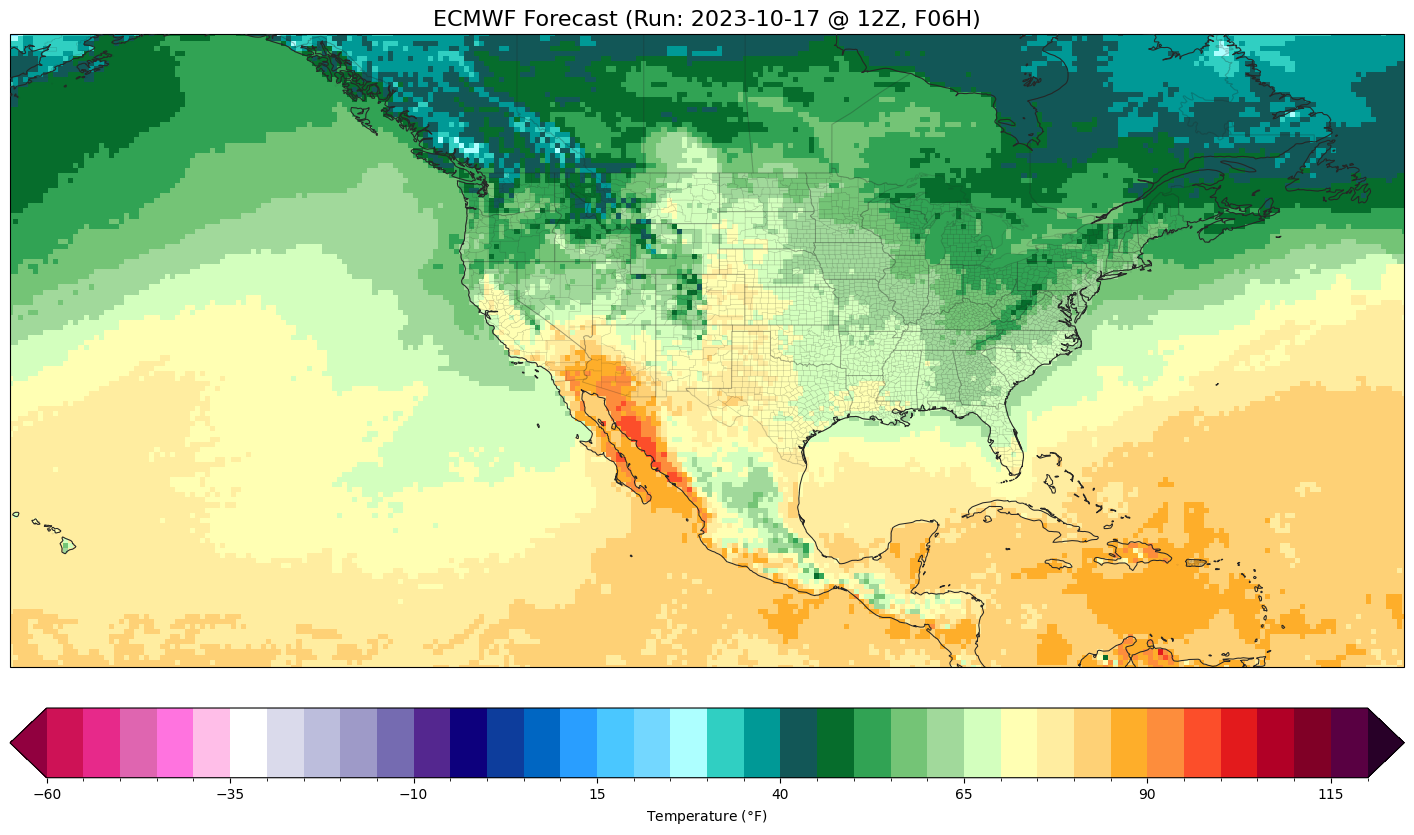

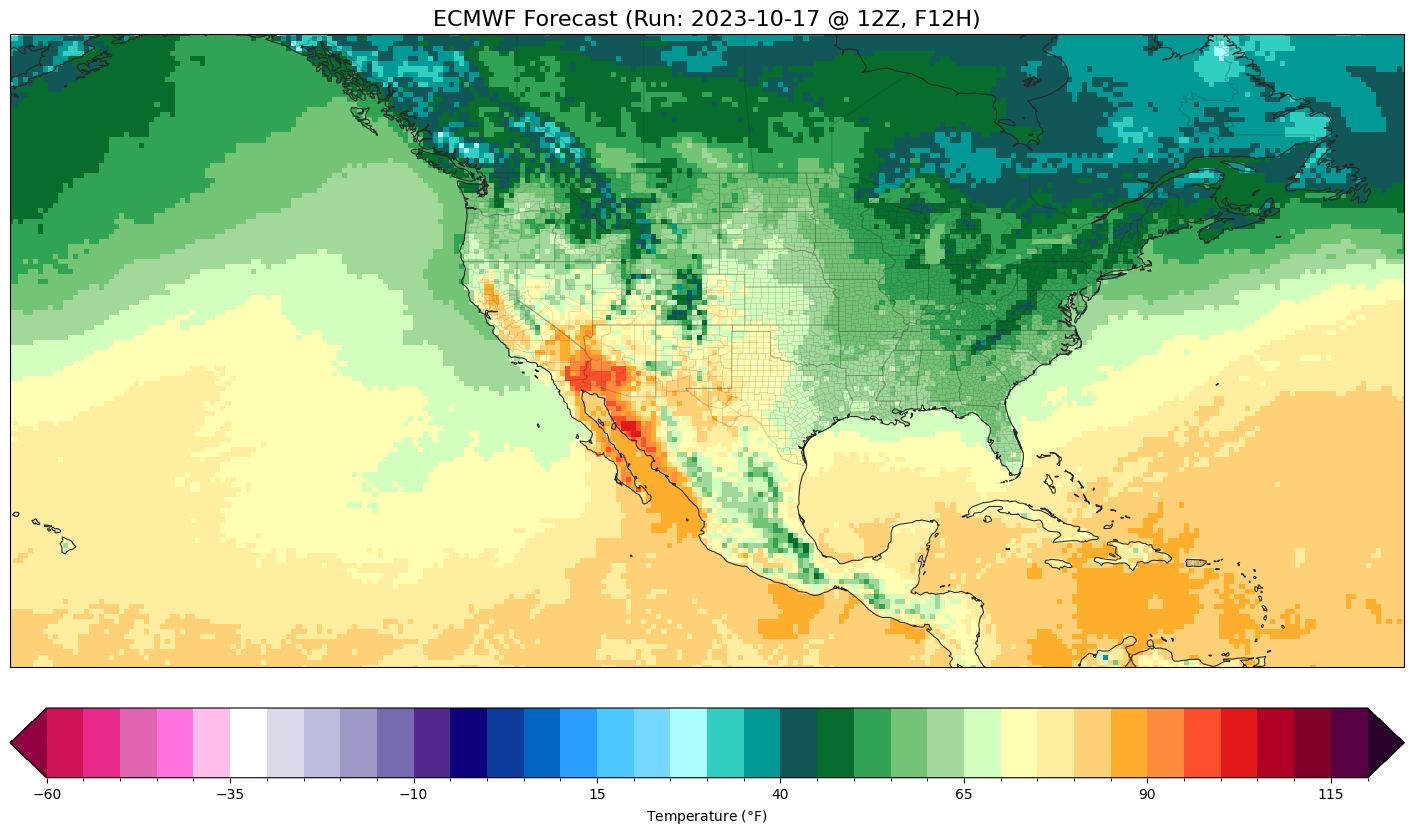

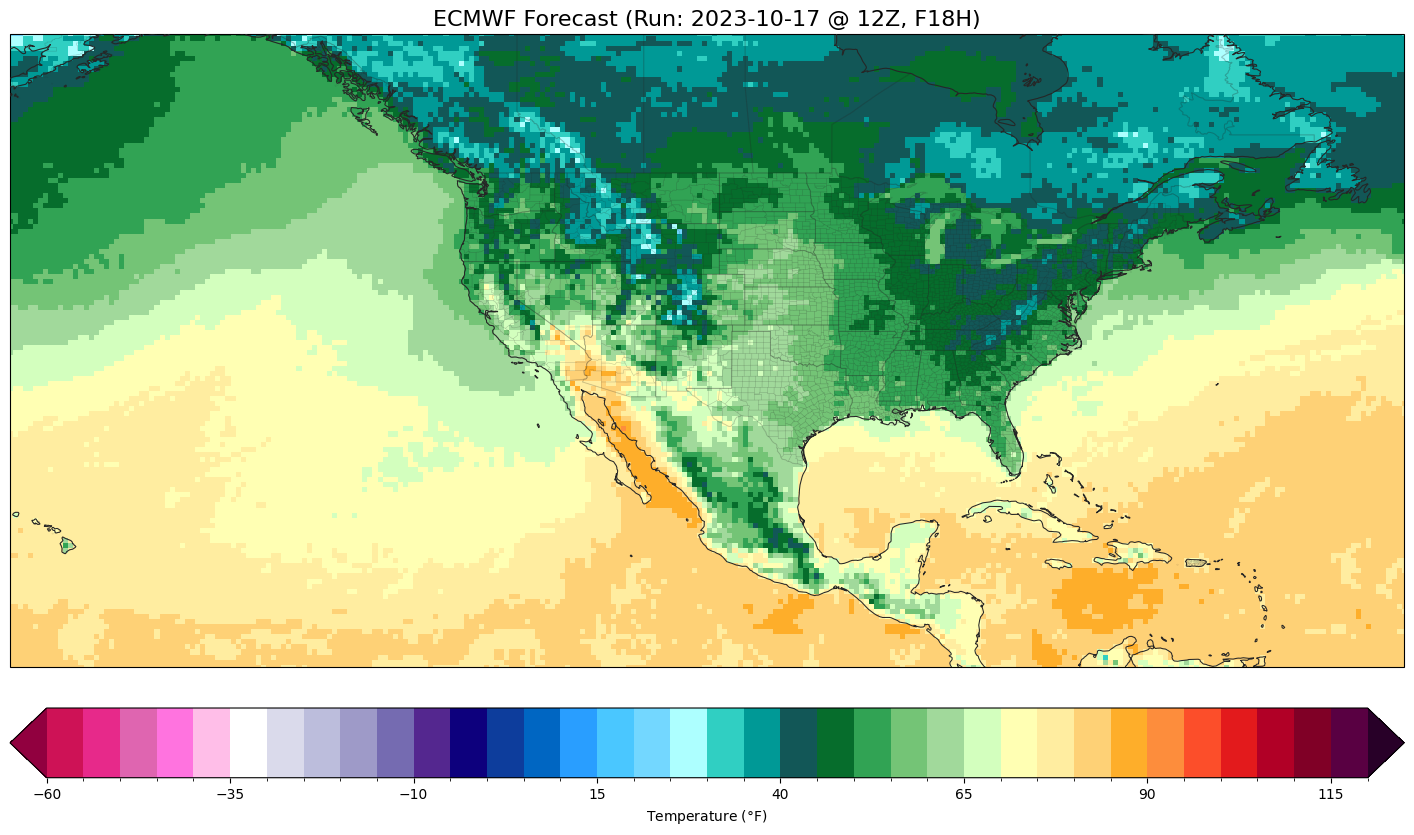

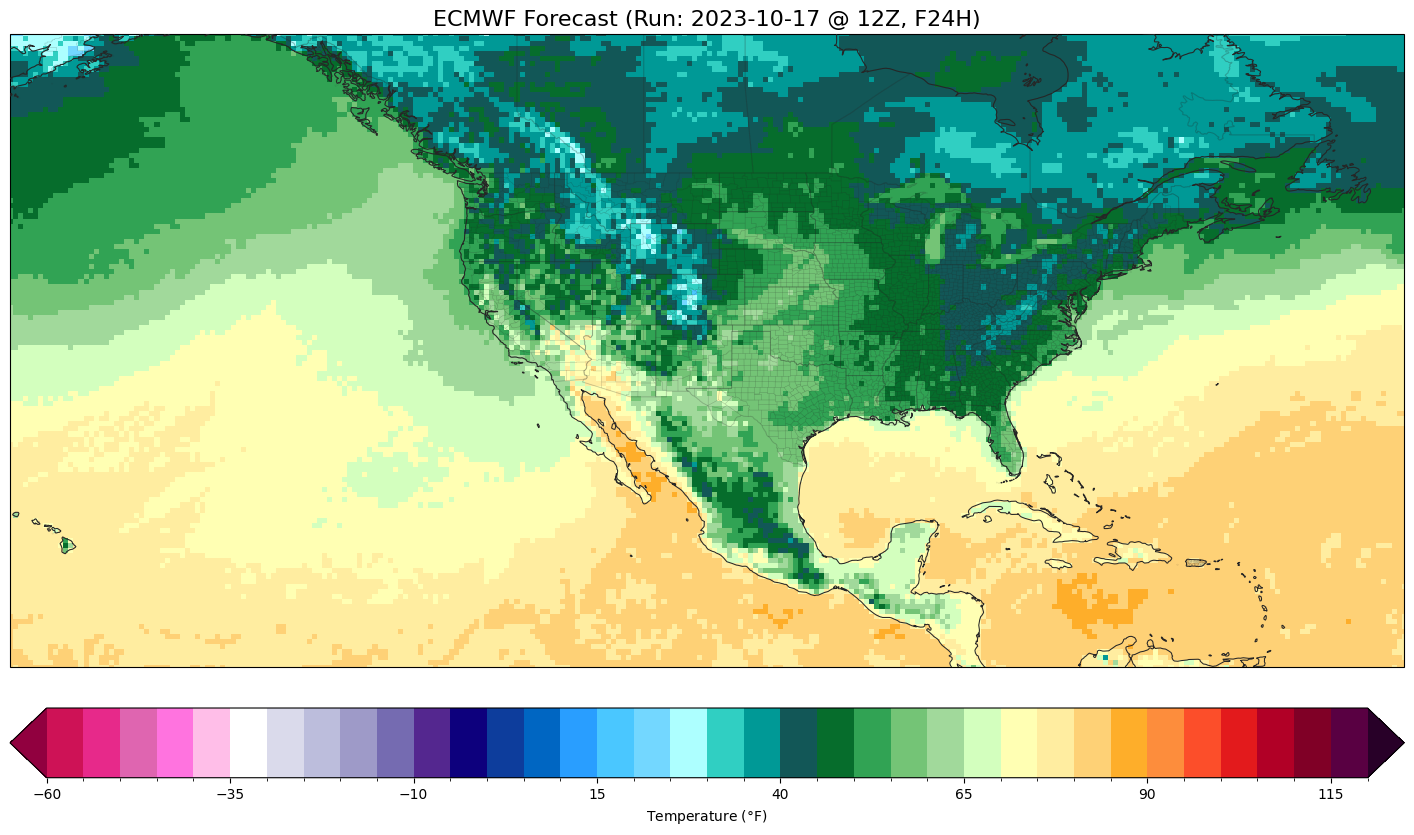

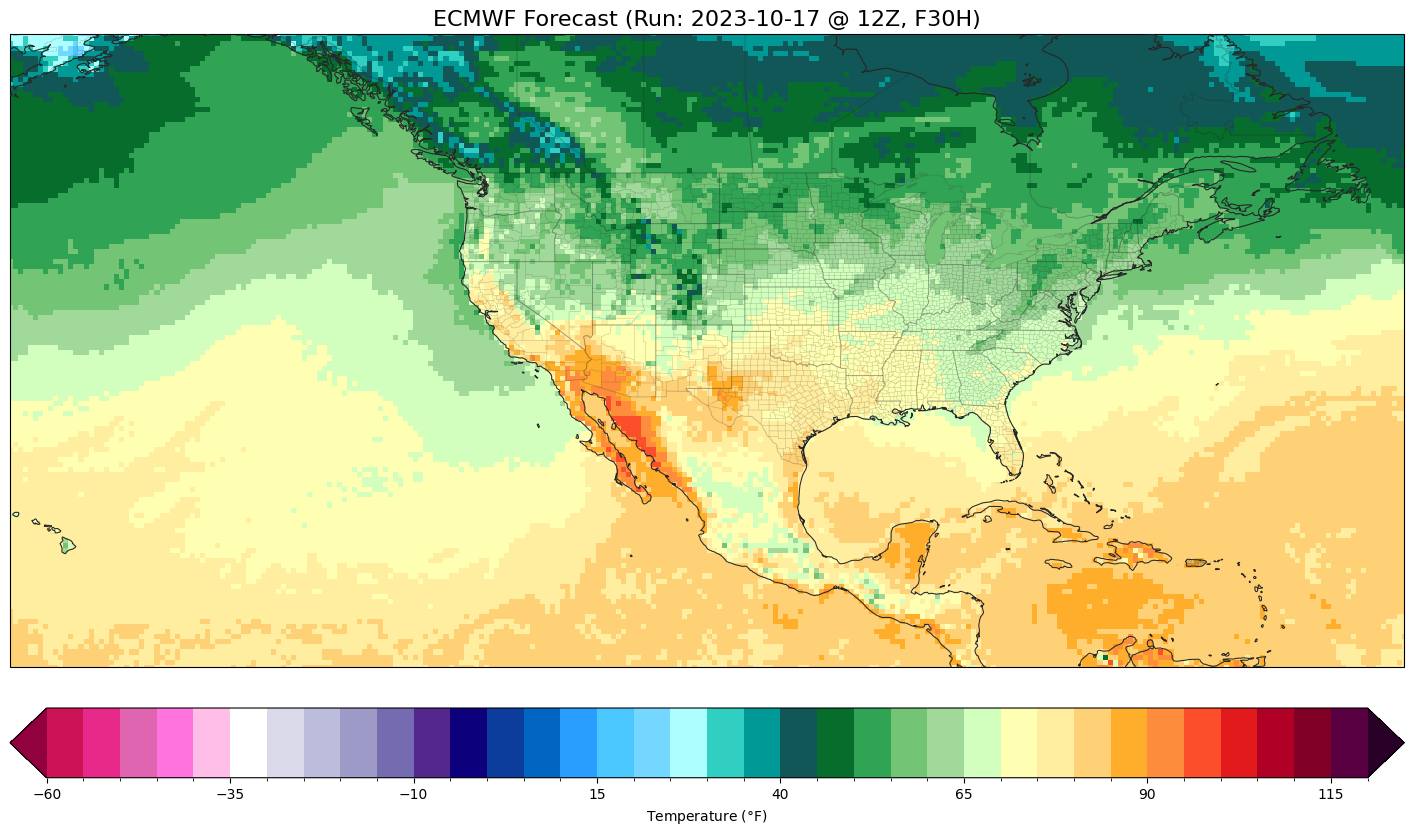

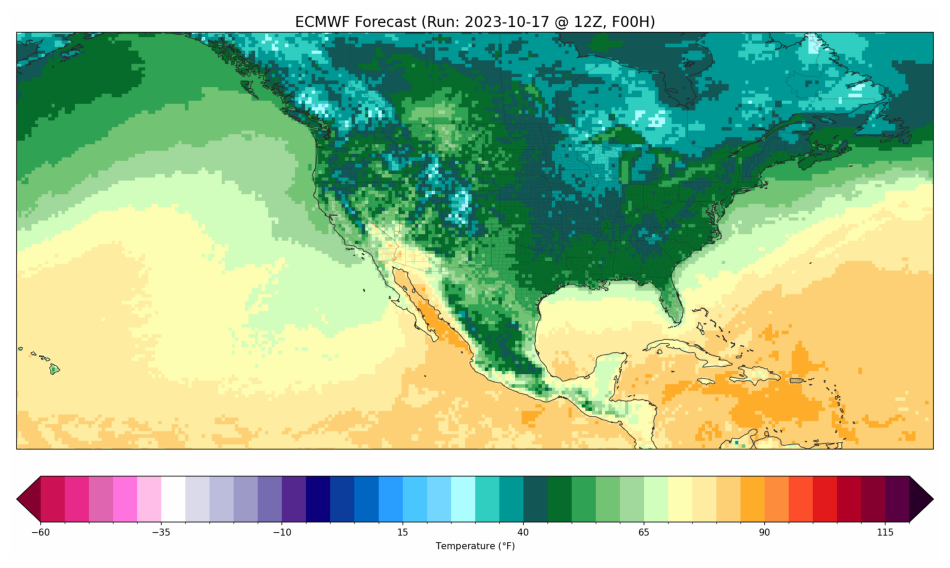

In [6]:
from herbie import Herbie
from toolbox import EasyMap, pc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import imageio.v2 as imageio_v2
from paint.standard2 import cm_tmp
from scipy.interpolate import interp1d

# Function Definitions
def interpolate_1D_array(arr, new_length):
    old_indices = np.linspace(0, len(arr) - 1, len(arr))
    new_indices = np.linspace(0, len(arr) - 1, new_length)
    interpolator = interp1d(old_indices, arr, kind='linear')
    return interpolator(new_indices)

def get_data(init_date, fxx):
    try:
        H = Herbie(
            init_date.strftime("%Y-%m-%d %H"),
            model="ecmwf",
            product="oper",
            fxx=fxx
        )
        ds = H.xarray(":2t:")
        return ds['t2m'].values, ds['longitude'].values, ds['latitude'].values
    except Exception as e:
        print(f"Error for fxx={fxx}: {e}")
        return None, None, None

# Initialization
init_date = datetime.strptime("2023-10-17 12", "%Y-%m-%d %H")
fxx_range = range(0, 36, 6)
frames = []

# Main Loop
for fxx in fxx_range:
    t2m_data, lon, lat = get_data(init_date, fxx)
    if t2m_data is not None:
        # Convert temperature data from Kelvin to Fahrenheit
        t2m_data_fahrenheit = (t2m_data - 273.15) * 9/5 + 32

        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(17.99, 10.59))
        EasyMap("50m", crs=ccrs.PlateCarree(), ax=ax).STATES().OCEAN().LAND().COUNTIES()
        ax.set_extent([-160, -50, 10, 60], crs=ccrs.PlateCarree())  # West # East # South # North

        p = ax.pcolormesh(
            lon, lat, t2m_data_fahrenheit,  # Using Fahrenheit data
            transform=ccrs.PlateCarree(),
            **cm_tmp(units="F").cmap_kwargs  # Update units to Fahrenheit
        )

        plt.colorbar(
            p, ax=ax, orientation="horizontal", pad=0.05, **cm_tmp(units="F").cbar_kwargs  # Update units to Fahrenheit
        )

        ax.set_title(f"ECMWF Forecast (Run: {init_date.strftime('%Y-%m-%d @ %H')}Z, F{fxx:02}H)", fontsize=16)
        frame_filename = f"temp_ecmwf_frame_{fxx}.png"
        plt.savefig(frame_filename, dpi=150, bbox_inches='tight', pad_inches=0.1)
        frames.append(frame_filename)

# Post-processing
with imageio_v2.get_writer('ecmwf_forecast.gif', mode='I', duration=500, loop=0) as writer:
    for frame_filename in frames:
        image = imageio_v2.imread(frame_filename)
        writer.append_data(image)

for frame_filename in frames:
    os.remove(frame_filename)

plt.figure(figsize=(12, 12))
plt.imshow(imageio_v2.imread('ecmwf_forecast.gif'))
plt.axis('off')
plt.show()
